# Credit Default Prediction – Final Machine Learning Project
### Gabriel PICARD Thibault PELOU Hugo PICARD IF5

**Dataset:**  
- `application_record.csv`: socio-economic information about clients  
- `credit_record.csv`: monthly credit status for each client  

**Objective**  
Predict whether a client has a bad default history or not.  
We model this as a **binary classification** problem:

- `target = 1`: client had at least one **bad status** in their credit history  
- `target = 0`: client never had a bad status  

We will:

1. Perform a **complete Exploratory Data Analysis (EDA)**:
   - structure, missing values, descriptive statistics
   - distribution of each variable (numeric & categorical)
   - correlation analysis and target relationships

2. Do **data preprocessing & feature engineering**:
   - clean and transform raw variables
   - handle missing values, scaling, encoding
   - drop useless features

3. Train and compare several **supervised learning models**:
   - Logistic Regression (baseline)
   - k-Nearest Neighbors (k-NN)
   - Decision Tree
   - Random Forest
   - Gradient Boosting
   - Support Vector Machine (SVM)
   - XGBoost
   - LightGBM
   - Ensemble (VotingClassifier)

4. Address **class imbalance**:
   - analyse `target` distribution
   - use `class_weight` and resampling (RandomOverSampler / SMOTE)

5. Tune hyperparameters with **GridSearchCV**.

6. Evaluate models with several **metrics**:
   - Accuracy
   - Precision, Recall, F1-score
   - ROC-AUC, PR-AUC
   - Confusion matrix

7. Perform an experiment with **PCA** (dimension reduction) and compare results.

8. Conclude with a **summary of results** and a **final recommended model**.

In [69]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC

from sklearn.decomposition import PCA

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    confusion_matrix,
    classification_report
)

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 4)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 2. Data Loading and Target Construction

1. Load `application_record.csv` and `credit_record.csv`.
2. Drop duplicates on `application_record` by `ID`.
3. From `credit_record`, identify customers with **at least one bad status**:
   - STATUS in {1, 2, 3, 4, 5} → "bad" month.
4. For each `ID`, create a flag:
   - `"Yes"` if at least one bad month,
   - `"No"` otherwise.
5. Merge this information to build a dataset `data`.
6. Define `target = 1` if `"Yes"`, else `0`.

In [70]:
app = pd.read_csv("application_record.csv")
credit = pd.read_csv("credit_record.csv")

print("Raw application shape:", app.shape)
print("Raw credit shape:", credit.shape)

app = app.drop_duplicates(subset="ID")
print("Application shape after dropping duplicates:", app.shape)

credit_flag = credit.copy()
credit_flag["value"] = None
credit_flag.loc[credit_flag["STATUS"].isin(["1", "2", "3", "4", "5"]), "value"] = "Yes"

countV = credit_flag.groupby("ID").count()
countV["value"] = countV["value"].astype(object)
countV.loc[countV["value"] > 0, "value"] = "Yes"
countV.loc[countV["value"] == 0, "value"] = "No"
countV = countV[["value"]]

data = pd.merge(app, countV, on="ID", how="inner")

data["target"] = (data["value"] == "Yes").astype(int)

print("Final merged dataset shape:", data.shape)
data.head()

Raw application shape: (438557, 18)
Raw credit shape: (1048575, 3)
Application shape after dropping duplicates: (438510, 18)
Final merged dataset shape: (36457, 20)


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,value,target
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,Yes,1
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,Yes,1
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,No,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,No,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,No,0


## 3. Initial Inspection

We start by exploring the structure of the merged dataset, such as the column names and data type, example rows, basic statistics and missing values


In [71]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   CODE_GENDER          36457 non-null  object 
 2   FLAG_OWN_CAR         36457 non-null  object 
 3   FLAG_OWN_REALTY      36457 non-null  object 
 4   CNT_CHILDREN         36457 non-null  int64  
 5   AMT_INCOME_TOTAL     36457 non-null  float64
 6   NAME_INCOME_TYPE     36457 non-null  object 
 7   NAME_EDUCATION_TYPE  36457 non-null  object 
 8   NAME_FAMILY_STATUS   36457 non-null  object 
 9   NAME_HOUSING_TYPE    36457 non-null  object 
 10  DAYS_BIRTH           36457 non-null  int64  
 11  DAYS_EMPLOYED        36457 non-null  int64  
 12  FLAG_MOBIL           36457 non-null  int64  
 13  FLAG_WORK_PHONE      36457 non-null  int64  
 14  FLAG_PHONE           36457 non-null  int64  
 15  FLAG_EMAIL           36457 non-null 

In [72]:
data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,value,target
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,Yes,1
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,Yes,1
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,No,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,No,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,No,0


In [73]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,36457.0,5.078227e+06,41875.240788,5008804.0,5042028.0,5074614.0,5115396.0,5150487.0
CNT_CHILDREN,36457.0,4.303152e-01,0.742367,0.0,0.0,0.0,1.0,19.0
AMT_INCOME_TOTAL,36457.0,1.866857e+05,101789.226482,27000.0,121500.0,157500.0,225000.0,1575000.0
DAYS_BIRTH,36457.0,-1.597517e+04,4200.549944,-25152.0,-19438.0,-15563.0,-12462.0,-7489.0
DAYS_EMPLOYED,36457.0,5.926294e+04,137651.334859,-15713.0,-3153.0,-1552.0,-408.0,365243.0
FLAG_MOBIL,36457.0,1.000000e+00,0.000000,1.0,1.0,1.0,1.0,1.0
FLAG_WORK_PHONE,36457.0,2.255260e-01,0.417934,0.0,0.0,0.0,0.0,1.0
FLAG_PHONE,36457.0,2.948131e-01,0.455965,0.0,0.0,0.0,1.0,1.0
FLAG_EMAIL,36457.0,8.972214e-02,0.285787,0.0,0.0,0.0,0.0,1.0
CNT_FAM_MEMBERS,36457.0,2.198453e+00,0.911686,1.0,2.0,2.0,3.0,20.0


In [74]:
missing_counts = data.isna().sum()
missing_percent = 100 * missing_counts / len(data)

missing_df = pd.DataFrame({
    "missing_count": missing_counts,
    "missing_percent": missing_percent
}).sort_values(by="missing_percent", ascending=False)

missing_df

,missing_count,missing_percent
OCCUPATION_TYPE,11323,31.058507
ID,0,0.000000
FLAG_OWN_CAR,0,0.000000
CODE_GENDER,0,0.000000
FLAG_OWN_REALTY,0,0.000000
CNT_CHILDREN,0,0.000000
NAME_INCOME_TYPE,0,0.000000
AMT_INCOME_TOTAL,0,0.000000
NAME_FAMILY_STATUS,0,0.000000
NAME_HOUSING_TYPE,0,0.000000


## 4. Target Variable Analysis and Imbalance

We analyse the distribution of the target variable:

- `0`: no default
- `1`: default

This gives us an idea of **class imbalance**, which will influence the choice of metrics and techniques (class weighting, resampling).


Target counts:
 target
0    32166
1     4291
Name: count, dtype: int64

Target percentage:
 target
0    88.22997
1    11.77003
Name: proportion, dtype: float64


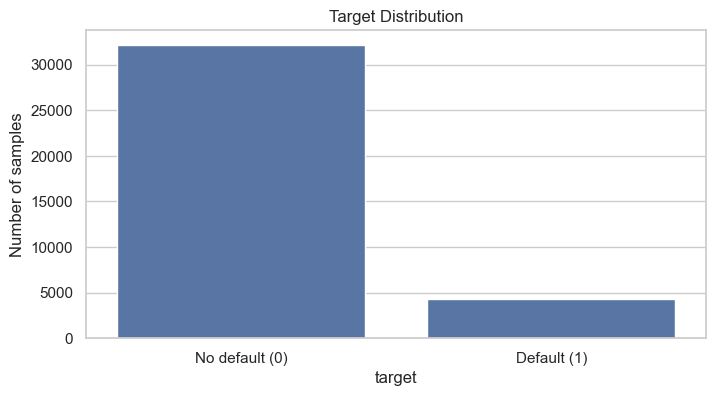

In [75]:
target_counts = data["target"].value_counts()
target_percent = data["target"].value_counts(normalize=True) * 100

print("Target counts:\n", target_counts)
print("\nTarget percentage:\n", target_percent)

plt.figure()
sns.barplot(x=target_counts.index, y=target_counts.values)
plt.xticks([0, 1], ["No default (0)", "Default (1)"])
plt.title("Target Distribution")
plt.ylabel("Number of samples")
plt.show()


## Conclusion on Oversampling the Dataset

The analysis of the target variable shows a strong imbalance:
- **88.23%** of class 0 (no default)
- **11.77%** of class 1 (default)

Such an uneven distribution means that, without correction, most models will naturally favor the majority class and fail to properly identify defaulting clients, which is the key objective in a credit risk context.
We will need to use oversampling techniques (such as RandomOverSampler or SMOTE) to help rebalance the dataset by increasing the representation of the minority class. This improves the model’s ability to learn meaningful patterns related to default cases and enhances metrics that are sensitive to imbalance, such as recall and F1-score.

## 5. Exploratory Data Analysis (EDA)

We now analyse each variable: separate **numerical** and **categorical** features, plot distributions and inspect outliers and potential data quality issues.

In [76]:
feature_cols = [c for c in data.columns if c not in ["ID", "target", "value"]]

numeric_cols = data[feature_cols].select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = data[feature_cols].select_dtypes(include=["object"]).columns.tolist()

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

Numeric columns: ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS']
Categorical columns: ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']


### 5.2 Numerical Features

For each numerical feature, we will display summary statistics and plot histograms.

This helps us understand ranges, skewness, and extreme values.

In [77]:
data[numeric_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
CNT_CHILDREN,36457.0,0.430315,0.742367,0.0,0.0,0.0,1.0,19.0
AMT_INCOME_TOTAL,36457.0,186685.736662,101789.226482,27000.0,121500.0,157500.0,225000.0,1575000.0
DAYS_BIRTH,36457.0,-15975.173382,4200.549944,-25152.0,-19438.0,-15563.0,-12462.0,-7489.0
DAYS_EMPLOYED,36457.0,59262.935568,137651.334859,-15713.0,-3153.0,-1552.0,-408.0,365243.0
FLAG_MOBIL,36457.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
FLAG_WORK_PHONE,36457.0,0.225526,0.417934,0.0,0.0,0.0,0.0,1.0
FLAG_PHONE,36457.0,0.294813,0.455965,0.0,0.0,0.0,1.0,1.0
FLAG_EMAIL,36457.0,0.089722,0.285787,0.0,0.0,0.0,0.0,1.0
CNT_FAM_MEMBERS,36457.0,2.198453,0.911686,1.0,2.0,2.0,3.0,20.0


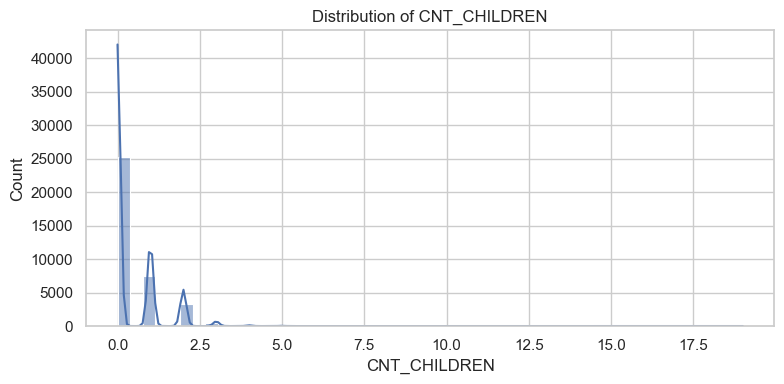

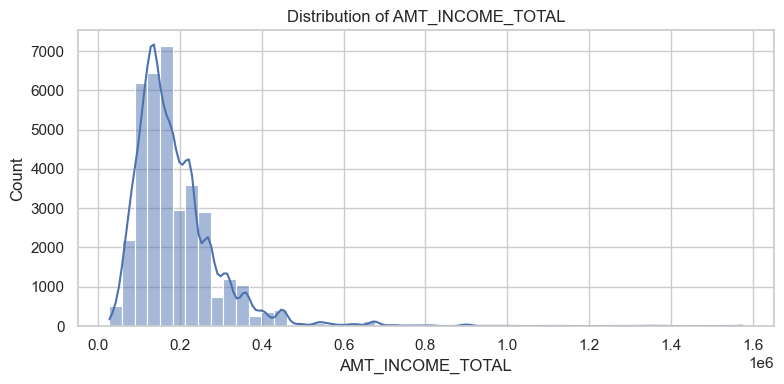

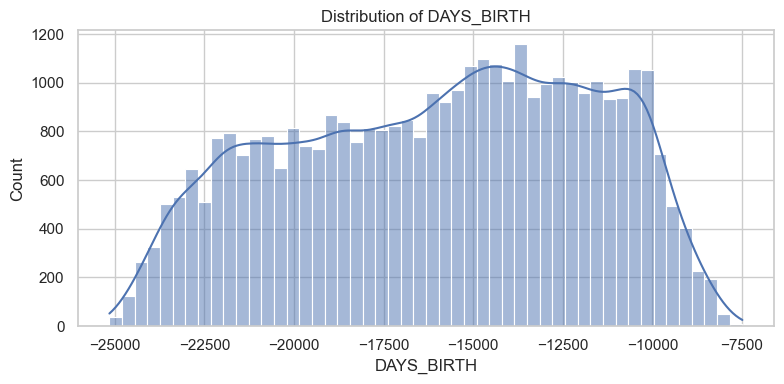

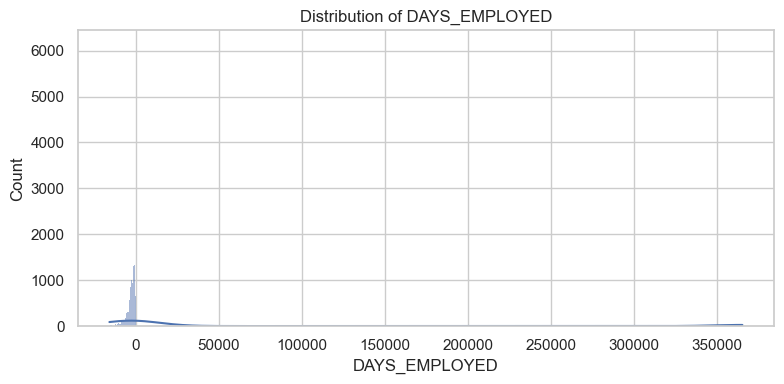

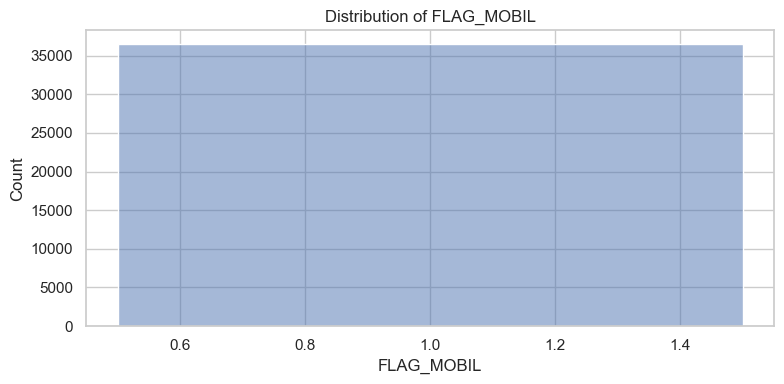

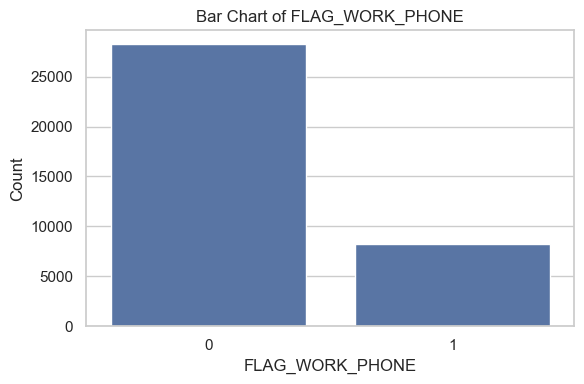

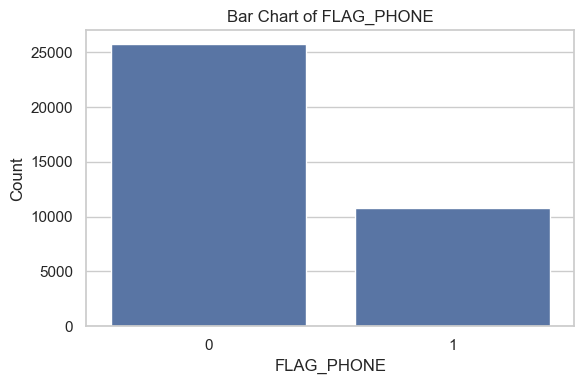

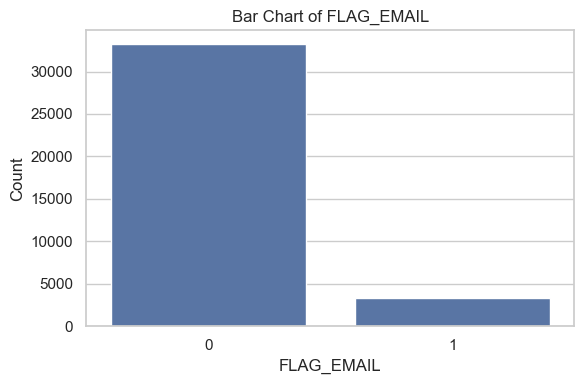

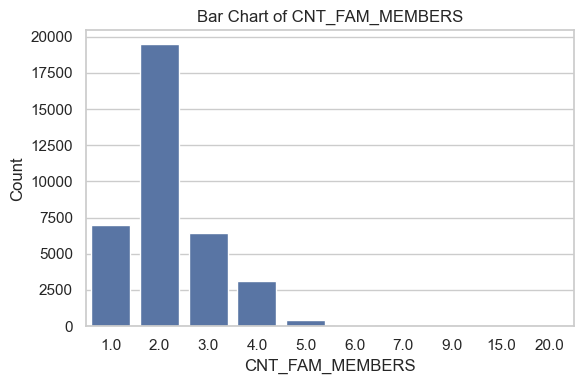

In [78]:
bar_chart_vars = ["CNT_FAM_MEMBERS", "FLAG_EMAIL", "FLAG_PHONE", "FLAG_WORK_PHONE"]

distribution_vars = ["CNT_CHILDREN", "AMT_INCOME_TOTAL", "DAYS_BIRTH"]

for col in numeric_cols:

    if col in bar_chart_vars:
        plt.figure(figsize=(6,4))
        sns.countplot(x=data[col], order=sorted(data[col].dropna().unique()))
        plt.title(f"Bar Chart of {col}")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()

    elif col in distribution_vars:
        plt.figure(figsize=(8,4))
        sns.histplot(data[col].dropna(), kde=True, bins=50)
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.tight_layout()
        plt.show()

    else:
        plt.figure(figsize=(8,4))
        sns.histplot(data[col].dropna(), kde=True)
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.tight_layout()
        plt.show()

# Descriptive Statistics Analysis and Interpretation


## 1. CNT_CHILDREN
Mean = **0.43**, Std = **0.74**
Median = **0**, with 75% of clients having **at most 1 child**
Maximum value = **19**, which is unusually high

**Conclusion:**  
Most clients have no children. The large maximum value is likely an outlier or data-entry issue and may need to be capped or removed to avoid distorting model learning.


## 2. AMT_INCOME_TOTAL
Mean = **186,686**, Std = **101,789**
Median = **157,500**, meaning income is right-skewed
Maximum income = **1,575,000**, far above typical values

**Conclusion:**  
Income distribution shows a long tail with very high-income individuals. A log transformation may help normalize the distribution. Extreme income outliers should be examined or capped.


## 3. DAYS_BIRTH
Mean = **-15,975 days ≈ 43.7 years**
Range corresponds to ages **20 to 70 years**

**Conclusion:**  
The variable behaves as expected. It represents age consistently, with no obvious anomalies. Transformation into age in years enhances readability.


## 🧑‍💼 4. DAYS_EMPLOYED
Mean = **59,263**, Std = **137,651**
Median = **-1,552 days (~4.2 years)**
Maximum = **365,243**, a known placeholder meaning *not employed*

**Conclusion:**  
This variable contains a special placeholder value that severely distorts the distribution.  
It should be replaced with `NaN` before modeling. Employment duration should also be converted into a clearer format (e.g., years).


## 5. FLAG_MOBIL
All values = **1**

**Conclusion:**  
The feature has zero variability and carries no predictive value. It should be dropped.


## 6. Communication Flags  
### FLAG_WORK_PHONE  
22.6% of clients have a work phone  
### FLAG_PHONE  
29.5% have a landline  
### FLAG_EMAIL  
Only 9% have an email address  

**Conclusion:**  
These variables show meaningful variability and may help the model capture differences in socio-economic characteristics.


## 7. CNT_FAM_MEMBERS
Mean = **2.20**
Most clients live in households of **2–3 members**
Maximum = **20**, which is unusually high

**Conclusion:**  
Family size generally follows reasonable patterns, but very large values may represent outliers. These extreme observations should be inspected or capped to avoid skewing model results.


# Overall Conclusions from Descriptive Statistics

Several variables contain **extreme outliers** (e.g., family size = 20, children = 19, income above 1.5M). These should be capped, transformed, or examined more closely.
**DAYS_EMPLOYED** contains a known placeholder value (**365243**) that must be handled because it distorts distribution metrics.
**FLAG_MOBIL** provides no useful information and should be removed.
Income is heavily skewed, suggesting that a **log transformation** could improve model performance.
Other variables show realistic distributions and appear suitable for modeling after minor cleaning steps.

### 5.3 Categorical Features

For categorical variables, we: compute value counts and plot bar charts for the most frequent categories.

This highlights dominant categories and potential rare levels that might be merged or grouped.


=== CODE_GENDER ===
CODE_GENDER
F    24430
M    12027
Name: count, dtype: int64


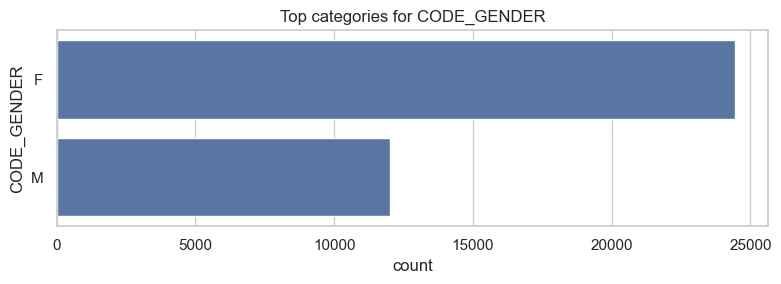


=== FLAG_OWN_CAR ===
FLAG_OWN_CAR
N    22614
Y    13843
Name: count, dtype: int64


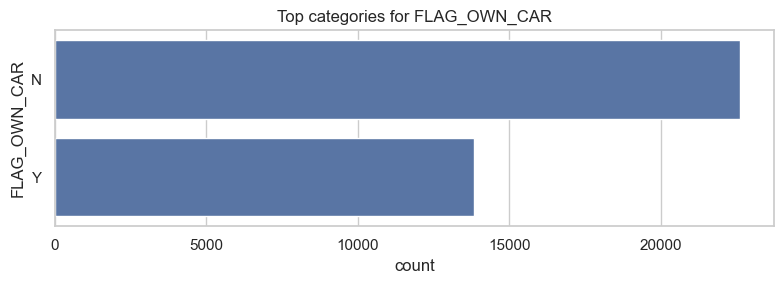


=== FLAG_OWN_REALTY ===
FLAG_OWN_REALTY
Y    24506
N    11951
Name: count, dtype: int64


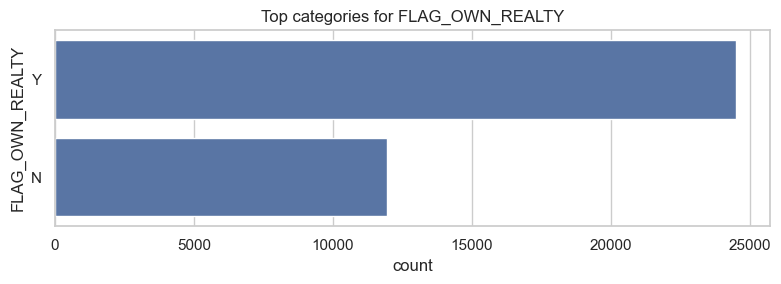


=== NAME_INCOME_TYPE ===
NAME_INCOME_TYPE
Working                 18819
Commercial associate     8490
Pensioner                6152
State servant            2985
Student                    11
Name: count, dtype: int64


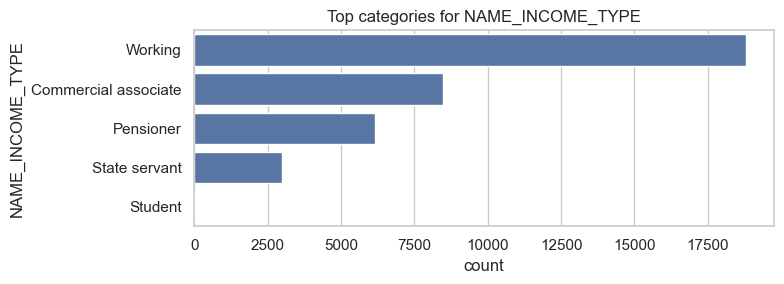


=== NAME_EDUCATION_TYPE ===
NAME_EDUCATION_TYPE
Secondary / secondary special    24777
Higher education                  9864
Incomplete higher                 1410
Lower secondary                    374
Academic degree                     32
Name: count, dtype: int64


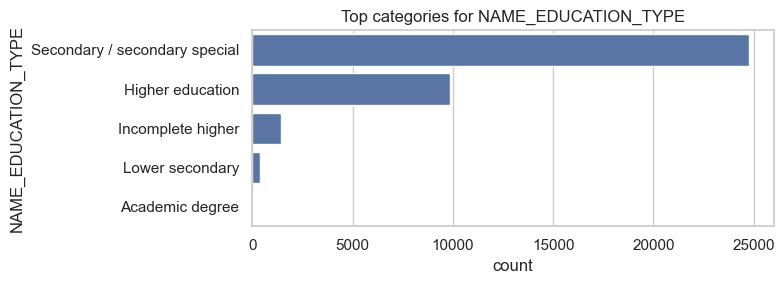


=== NAME_FAMILY_STATUS ===
NAME_FAMILY_STATUS
Married                 25048
Single / not married     4829
Civil marriage           2945
Separated                2103
Widow                    1532
Name: count, dtype: int64


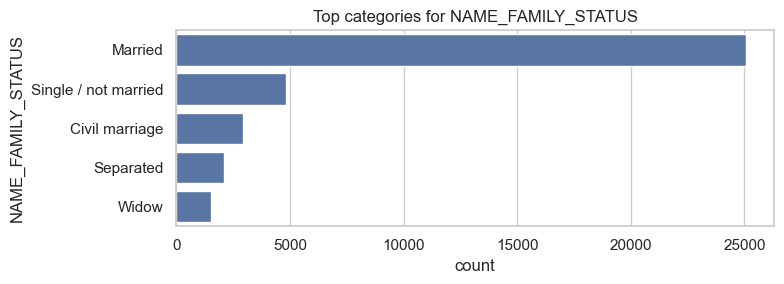


=== NAME_HOUSING_TYPE ===
NAME_HOUSING_TYPE
House / apartment      32548
With parents            1776
Municipal apartment     1128
Rented apartment         575
Office apartment         262
Co-op apartment          168
Name: count, dtype: int64


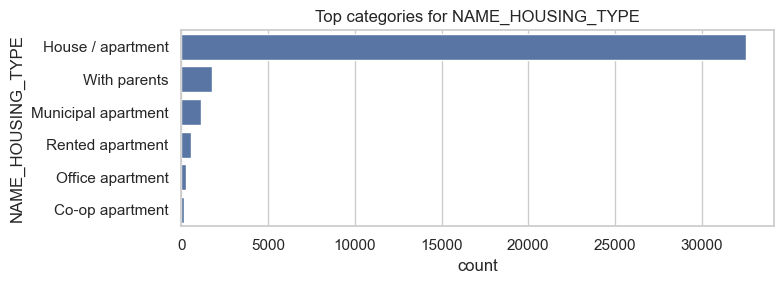


=== OCCUPATION_TYPE ===
OCCUPATION_TYPE
NaN                      11323
Laborers                  6211
Core staff                3591
Sales staff               3485
Managers                  3012
Drivers                   2138
High skill tech staff     1383
Accountants               1241
Medicine staff            1207
Cooking staff              655
Name: count, dtype: int64


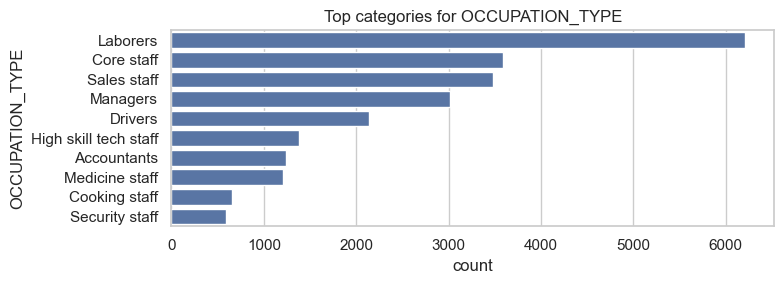

In [79]:
for col in categorical_cols:
    print(f"\n=== {col} ===")
    print(data[col].value_counts(dropna=False).head(10))
    
    plt.figure(figsize=(8, 3))
    sns.countplot(
        y=col,
        data=data,
        order=data[col].value_counts().index[:10]
    )
    plt.title(f"Top categories for {col}")
    plt.tight_layout()
    plt.show()


# Analysis of Categorical Variables

This section analyzes the main categorical variables in the dataset. These variables capture demographic, socio-economic, and household information that may affect credit behavior.


## 1. CODE_GENDER
**Female:** 24,430  
**Male:** 12,027  

**Interpretation:**  
The dataset contains approximately **twice as many women as men**. This likely reflects the actual client population rather than sampling bias. Gender may correlate with income, employment type, or risk profile, and should be kept as a predictive variable.


## 2. FLAG_OWN_CAR
**No:** 22,614  
**Yes:** 13,843  

**Interpretation:**  
Around **38% of clients own a car**. Car ownership can serve as a proxy for mobility and socio-economic stability, potentially contributing useful predictive information.


## 3. FLAG_OWN_REALTY
**Yes:** 24,506  
**No:** 11,951  

**Interpretation:**  
Nearly **two-thirds of clients own real estate**, a factor strongly associated with wealth, stability, and long-term residency. This variable is likely to be an important predictor of creditworthiness.


## 4. NAME_INCOME_TYPE
**Working:** 18,819  
**Commercial associate:** 8,490  
**Pensioner:** 6,152  
**State servant:** 2,985  
**Student:** 11  

**Interpretation:**  
Most clients are **working professionals** or **commercial associates**. Pensioners represent a sizable group with stable income. Students are extremely rare (<0.05%) and will have negligible impact on the model. Income type clearly divides the population into meaningful categories.


## 5. NAME_EDUCATION_TYPE
**Secondary / secondary special:** 24,777  
**Higher education:** 9,864  
**Incomplete higher:** 1,410  
**Lower secondary:** 374  
**Academic degree:** 32  

**Interpretation:**  
A large majority of clients have **secondary education**, while about **27% hold a higher education degree**. Very high academic levels are extremely rare. Education level is likely to correlate with income and credit stability.


## 6. NAME_FAMILY_STATUS
**Married:** 25,048  
**Single / not married:** 4,829  
**Civil marriage:** 2,945  
**Separated:** 2,103  
**Widow:** 1,532  

**Interpretation:**  
Most clients are **married**, representing more than two-thirds of the dataset. Family status may influence household income and financial obligations, making this a potentially important predictor.


## 7. NAME_HOUSING_TYPE
**House / apartment:** 32,548  
**With parents:** 1,776  
**Municipal apartment:** 1,128  
**Rented apartment:** 575  
**Office apartment:** 262  
**Co-op apartment:** 168  

**Interpretation:**  
Most clients live in a **house or apartment**, indicating a relatively stable living situation. Other categories exist but in small proportions. These rare categories may be left as-is or grouped depending on modeling needs.

## 🛠 8. OCCUPATION_TYPE
**Missing:** 11,323  
**Laborers:** 6,211  
**Core staff:** 3,591  
**Sales staff:** 3,485  
**Managers:** 3,012  
**Drivers:** 2,138  
**High skill tech staff:** 1,383  
**Accountants:** 1,241  
**Medicine staff:** 1,207  
**Cooking staff:** 655  

**Interpretation:**  
About **31% of occupation data is missing**, requiring special handling (e.g., imputation with "Unknown" or treating missingness as a separate category). Among the known categories, the dataset includes a wide range of professions. Occupational diversity is a strong source of predictive signal, and the missingness itself may also carry useful information (e.g., informal or undocumented employment).


# Overall Conclusions

The dataset's categorical variables exhibit **good variability** and are likely to contribute significantly to predictive performance.
Some categories (e.g., students, academic degree holders) are extremely rare and may have limited impact.
**OCCUPATION_TYPE** presents a high proportion of missing values, requiring careful preprocessing.
Home ownership and car ownership appear particularly informative of financial stability.
The typical profile in this dataset is:
Female  
Working  
Secondary-educated  
Married  
Living in a house or apartment  

These socio-economic patterns may correlate strongly with credit default risk and should be preserved during encoding and modeling.

## 6. Feature Engineering and Data Cleaning

### 6.1 Numerical Feature Cleaning and Engineering
Converted `DAYS_BIRTH` into a readable **AGE_YEARS** feature.
Corrected `DAYS_EMPLOYED` by replacing the placeholder value `365243` with `NaN`.
Created **EMPLOYED_YEARS** (duration of employment) and a binary **IS_WORKING** indicator.
Applied a **log transformation** to `AMT_INCOME_TOTAL` to reduce skew (`AMT_INCOME_LOG`).
Capped extreme outliers for:
- `CNT_CHILDREN` (max 10)
- `CNT_FAM_MEMBERS` (max 10)
- `AMT_INCOME_TOTAL` (max 1,000,000)
  Removed `FLAG_MOBIL` because it contains only one value.

### 6.2 Categorical Feature Cleaning
Grouped rare categories in `NAME_INCOME_TYPE` into `"Other"`.
Merged rare or redundant categories in `NAME_EDUCATION_TYPE`.
Grouped uncommon housing types in `NAME_HOUSING_TYPE` into `"Other"`.
Cleaned `OCCUPATION_TYPE` by:
- replacing missing values with `"Unknown"`
- grouping rare occupations into `"Other"`


In [80]:
df = data.copy()

df["DAYS_EMPLOYED"] = df["DAYS_EMPLOYED"].replace(365243, np.nan)

df["EMPLOYED_YEARS"] = (-df["DAYS_EMPLOYED"] / 365).round(1)

df["IS_WORKING"] = df["EMPLOYED_YEARS"].notna().astype(int)

df["AGE_YEARS"] = (-df["DAYS_BIRTH"] / 365).round(1)

df["AMT_INCOME_LOG"] = np.log1p(df["AMT_INCOME_TOTAL"])

df["CNT_CHILDREN"] = df["CNT_CHILDREN"].clip(upper=10)
df["CNT_FAM_MEMBERS"] = df["CNT_FAM_MEMBERS"].clip(upper=10)
df["AMT_INCOME_TOTAL"] = df["AMT_INCOME_TOTAL"].clip(upper=1_000_000)

df = df.drop(columns=["FLAG_MOBIL"])

income_map = df["NAME_INCOME_TYPE"].value_counts()
rare_income = income_map[income_map < 100].index.tolist()

df["NAME_INCOME_TYPE"] = df["NAME_INCOME_TYPE"].replace(rare_income, "Other")

df["NAME_EDUCATION_TYPE"] = df["NAME_EDUCATION_TYPE"].replace({
    "Academic degree": "Higher education",
    "Lower secondary": "Secondary / secondary special"
})

housing_map = df["NAME_HOUSING_TYPE"].value_counts()
rare_housing = housing_map[housing_map < 1000].index.tolist()

df["NAME_HOUSING_TYPE"] = df["NAME_HOUSING_TYPE"].replace(rare_housing, "Other")

df["OCCUPATION_TYPE"] = df["OCCUPATION_TYPE"].fillna("Unknown")

occ_map = df["OCCUPATION_TYPE"].value_counts()
rare_occupations = occ_map[occ_map < 500].index.tolist()

df["OCCUPATION_TYPE"] = df["OCCUPATION_TYPE"].replace(rare_occupations, "Other")

df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,value,target,EMPLOYED_YEARS,IS_WORKING,AGE_YEARS,AMT_INCOME_LOG
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Other,...,0,0,Unknown,2.0,Yes,1,12.4,1,32.9,12.965712
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Other,...,0,0,Unknown,2.0,Yes,1,12.4,1,32.9,12.965712
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,0,0,Security staff,2.0,No,0,3.1,1,58.8,11.630717
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,1,1,Sales staff,1.0,No,0,8.4,1,52.4,12.506181
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,1,1,Sales staff,1.0,No,0,8.4,1,52.4,12.506181


In [81]:
feature_cols = [c for c in df.columns if c != "target"]

numeric_cols = df[feature_cols].select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = df[feature_cols].select_dtypes(include=["object"]).columns.tolist()

print("Numeric features:", numeric_cols)
print("Categorical features:", categorical_cols)

Numeric features: ['ID', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'EMPLOYED_YEARS', 'IS_WORKING', 'AGE_YEARS', 'AMT_INCOME_LOG']
Categorical features: ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'value']


## 7. Correlation Analysis

We compute the **correlation matrix** for numerical features to detect possible multicollinearity and identify variables most correlated with `target`.

For the target (binary), we consider its correlation with numeric features as a first proxy for feature importance.

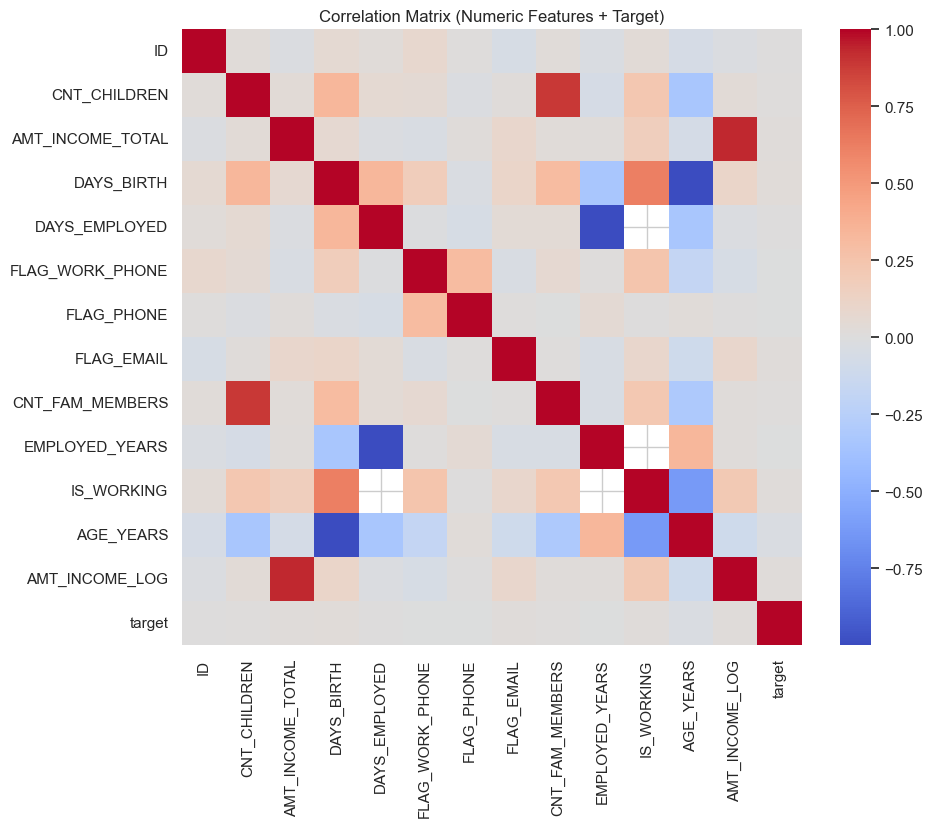

target              1.000000
DAYS_BIRTH          0.028943
AMT_INCOME_TOTAL    0.023016
IS_WORKING          0.021635
FLAG_EMAIL          0.019658
AMT_INCOME_LOG      0.018680
CNT_CHILDREN        0.011038
CNT_FAM_MEMBERS     0.008424
DAYS_EMPLOYED       0.004633
ID                  0.003565
FLAG_WORK_PHONE    -0.000149
EMPLOYED_YEARS     -0.004609
FLAG_PHONE         -0.006355
AGE_YEARS          -0.028930
Name: target, dtype: float64

In [82]:
corr_matrix = df[numeric_cols + ["target"]].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Matrix (Numeric Features + Target)")
plt.show()

corr_target = corr_matrix["target"].sort_values(ascending=False)
corr_target

## Correlation Analysis with the Target Variable

The correlation values between each numerical feature and the target (default = 1) are all very low.

### Key Observations

**No feature shows strong linear correlation with the target**, with all correlations below 0.03 in absolute value.
The most positively correlated features are:
- **DAYS_BIRTH (0.0289)** → younger clients appear slightly more likely to default.
- **AMT_INCOME_TOTAL (0.0230)** and **AMT_INCOME_LOG (0.0187)** → lower income might weakly relate to higher risk, but linear correlation is very limited.
- **IS_WORKING (0.0216)** and **FLAG_EMAIL (0.0197)** show small positive relationships, possibly reflecting stability or accessibility factors.

Features with small negative correlations include:
- **AGE_YEARS (-0.0289)** → consistent with the DAYS_BIRTH finding (younger clients default slightly more).
- **FLAG_PHONE (-0.0064)** and **EMPLOYED_YEARS (-0.0046)** indicate extremely weak inverse associations.

### Interpretation

These correlations are very close to zero, meaning **no single numerical feature linearly explains default risk**. This correlation matrix didn't really helped us.

## 8. Train / Test Split and Preprocessing

We now prepare the data for modeling:

1. Split into **train** and **test** sets with stratification on `target`.
2. Build a **preprocessing pipeline** using `ColumnTransformer`:
   - Numeric features:
     - impute missing values with median,
     - standard scaling.
   - Categorical features:
     - impute with most frequent,
     - one-hot encoding (`OneHotEncoder` with `handle_unknown="ignore"`).

This follows the ML pipeline principles from the labs (scaling + model, reproducible workflow). 

In [83]:
cols_to_remove = ["target", "value", "ID", "DAYS_BIRTH", "DAYS_EMPLOYED"]

df_model = df.drop(columns=cols_to_remove, errors="ignore")

numeric_cols = df_model.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = df_model.select_dtypes(include=["object"]).columns.tolist()

feature_cols = numeric_cols + categorical_cols

X = df[feature_cols]
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=RANDOM_STATE,
    stratify=y
)

In [84]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

## 9. Helper Function for Model Evaluation

We define a reusable function to:

- fit a (pipeline) model
- compute multiple metrics:
  - Accuracy, Precision, Recall, F1
  - ROC-AUC (if `predict_proba` is available)
- optionally plot ROC and Precision–Recall curves.


In [85]:
def evaluate_model(name, model, X_train, X_test, y_train, y_test, plot_curves=False):

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    metrics = {}
    metrics["Model"] = name
    metrics["Accuracy"] = accuracy_score(y_test, y_pred)
    metrics["Precision"] = precision_score(y_test, y_pred)
    metrics["Recall"] = recall_score(y_test, y_pred)
    metrics["F1"] = f1_score(y_test, y_pred)

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        metrics["ROC_AUC"] = roc_auc_score(y_test, y_proba)
    else:
        metrics["ROC_AUC"] = np.nan
        y_proba = None
    
    print(f"\n=== {name} ===")
    print("Accuracy :", metrics["Accuracy"])
    print("Precision:", metrics["Precision"])
    print("Recall   :", metrics["Recall"])
    print("F1-score :", metrics["F1"])
    print("ROC-AUC  :", metrics["ROC_AUC"])
    print("\nClassification report:\n")
    print(classification_report(y_test, y_pred))
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    if plot_curves and y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        prec, rec, _ = precision_recall_curve(y_test, y_proba)
        
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(fpr, tpr)
        plt.plot([0, 1], [0, 1], "--")
        plt.title(f"ROC Curve – {name}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")

        plt.subplot(1, 2, 2)
        plt.plot(rec, prec)
        plt.title(f"Precision–Recall Curve – {name}")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        
        plt.tight_layout()
        plt.show()
    
    return metrics

## 10. Baseline Model – Logistic Regression

We start with a **baseline logistic regression** model:

- use the preprocessing pipeline defined above,
- set `class_weight="balanced"` to partially correct class imbalance (more weight on default class).

This is in line with the lab on logistic regression and imbalanced data. 



=== Logistic Regression (baseline) ===
Accuracy : 0.5840190162735418
Precision: 0.1378468368479467
Recall   : 0.4825174825174825
F1-score : 0.21443370165745856
ROC-AUC  : 0.550060434735598

Classification report:

              precision    recall  f1-score   support

           0       0.90      0.60      0.72      9651
           1       0.14      0.48      0.21      1287

    accuracy                           0.58     10938
   macro avg       0.52      0.54      0.47     10938
weighted avg       0.81      0.58      0.66     10938

Confusion matrix:
[[5767 3884]
 [ 666  621]]


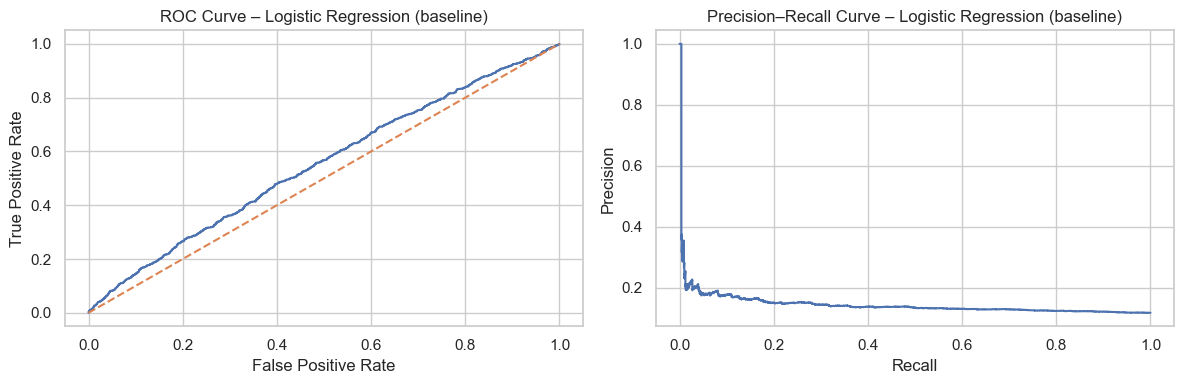

In [86]:
log_reg = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=RANDOM_STATE
    ))
])

baseline_metrics = evaluate_model(
    "Logistic Regression (baseline)",
    log_reg,
    X_train, X_test, y_train, y_test,
    plot_curves=True
)


## 11. Handling Class Imbalance with Resampling (Optional)

We saw in the EDA that the default class (`target=1`) is under-represented.

In addition to `class_weight`, we can also try **oversampling**:

- **RandomOverSampler**: duplicates minority class samples,
- **SMOTE**: synthetically generates new minority samples in feature space.

We integrate oversampling inside the pipeline, before the model. :contentReference[oaicite:3]{index=3}


In [87]:
resampled_metrics = []

log_reg_ros = ImbPipeline(steps=[
        ("preprocess", preprocessor),
        ("ros", RandomOverSampler(random_state=RANDOM_STATE)),
        ("model", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])
    
resampled_metrics.append(
    evaluate_model("Logistic Regression + RandomOverSampler",
                   log_reg_ros, X_train, X_test, y_train, y_test,
                   plot_curves=False)
)
log_reg_smote = ImbPipeline(steps=[
    ("preprocess", preprocessor),
    ("smote", SMOTE(random_state=RANDOM_STATE)),
    ("model", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

resampled_metrics.append(
    evaluate_model("Logistic Regression + SMOTE",
                   log_reg_smote, X_train, X_test, y_train, y_test,
                   plot_curves=False)
)


=== Logistic Regression + RandomOverSampler ===
Accuracy : 0.5764307917352349
Precision: 0.13772195755738414
Recall   : 0.49417249417249415
F1-score : 0.21541066892464014
ROC-AUC  : 0.552176797747205

Classification report:

              precision    recall  f1-score   support

           0       0.90      0.59      0.71      9651
           1       0.14      0.49      0.22      1287

    accuracy                           0.58     10938
   macro avg       0.52      0.54      0.46     10938
weighted avg       0.81      0.58      0.65     10938

Confusion matrix:
[[5669 3982]
 [ 651  636]]

=== Logistic Regression + SMOTE ===
Accuracy : 0.5544889376485647
Precision: 0.13030927835051545
Recall   : 0.49106449106449107
F1-score : 0.20596382597360274
ROC-AUC  : 0.5420101721003182

Classification report:

              precision    recall  f1-score   support

           0       0.89      0.56      0.69      9651
           1       0.13      0.49      0.21      1287

    accuracy           

## 12. Comparison of Standard Models

We now compare several algorithms:

- Logistic Regression (baseline, already evaluated)
- k-Nearest Neighbors
- Decision Tree
- Random Forest
- Gradient Boosting
- Support Vector Machine (SVM)
- XGBoost
- LightBoost

Each model is wrapped inside a pipeline with **shared preprocessing**.


In [88]:
results = []

results.append(baseline_metrics)

models = {
    "k-NN": KNeighborsClassifier(n_neighbors=15),
    "Decision Tree": DecisionTreeClassifier(
        random_state=RANDOM_STATE,
        class_weight="balanced"
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        random_state=RANDOM_STATE,
        class_weight="balanced",
        n_jobs=-1
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        random_state=RANDOM_STATE
    ),
    "SVM (RBF)": SVC(
        kernel="rbf",
        probability=True,
        class_weight="balanced",
        random_state=RANDOM_STATE
    ),
    "XGBoost": XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=RANDOM_STATE
    ),
    "LightGBM": LGBMClassifier(
        n_estimators=300,
        learning_rate=0.05,
        num_leaves=31,
        max_depth=-1,
        random_state=RANDOM_STATE
    )
}

for name, clf in models.items():
    pipe = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", clf)
    ])
    metrics = evaluate_model(name, pipe, X_train, X_test, y_train, y_test, plot_curves=False)
    results.append(metrics)

results_df = pd.DataFrame(results)
results_df.sort_values(by="F1", ascending=False)


=== k-NN ===
Accuracy : 0.8817882611080636
Precision: 0.44642857142857145
Recall   : 0.019425019425019424
F1-score : 0.03723008190618019
ROC-AUC  : 0.660751123293865

Classification report:

              precision    recall  f1-score   support

           0       0.88      1.00      0.94      9651
           1       0.45      0.02      0.04      1287

    accuracy                           0.88     10938
   macro avg       0.67      0.51      0.49     10938
weighted avg       0.83      0.88      0.83     10938

Confusion matrix:
[[9620   31]
 [1262   25]]

=== Decision Tree ===
Accuracy : 0.789723898336076
Precision: 0.30571538166474876
Recall   : 0.6192696192696193
F1-score : 0.4093477144324602
ROC-AUC  : 0.7361151667959254

Classification report:

              precision    recall  f1-score   support

           0       0.94      0.81      0.87      9651
           1       0.31      0.62      0.41      1287

    accuracy                           0.79     10938
   macro avg       0

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,Model,Accuracy,Precision,Recall,F1,ROC_AUC
3,Random Forest,0.836899,0.362631,0.509713,0.423773,0.783825
2,Decision Tree,0.789724,0.305715,0.619270,0.409348,0.736115
5,SVM (RBF),0.660907,0.180812,0.533023,0.270026,0.650721
0,Logistic Regression (baseline),0.584019,0.137847,0.482517,0.214434,0.550060
6,XGBoost,0.885262,0.650943,0.053613,0.099067,0.710068
7,LightGBM,0.883982,0.586538,0.047397,0.087707,0.715397
1,k-NN,0.881788,0.446429,0.019425,0.037230,0.660751
4,Gradient Boosting,0.882337,0.500000,0.003108,0.006178,0.590681


In [89]:
imbalance_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
print("Imbalance ratio:", imbalance_ratio)

boosting_models = {
    "XGBoost Optimized": XGBClassifier(
        n_estimators=600,
        learning_rate=0.03,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.7,
        scale_pos_weight=imbalance_ratio,
        eval_metric="logloss",
        tree_method="hist",
        random_state=RANDOM_STATE
    ),

    # Version LightGBM corrigée & stable
    "LightGBM Optimized": LGBMClassifier(
        n_estimators=400,
        learning_rate=0.05,
        num_leaves=31,
        min_data_in_leaf=50,
        max_depth=-1,
        subsample=1.0,
        colsample_bytree=1.0,
        class_weight="balanced",
        random_state=RANDOM_STATE
    )
}

for name, clf in boosting_models.items():

    pipe = Pipeline(steps=[
        ("preprocess", preprocessor),   # garantit des features valides
        ("model", clf)
    ])

    metrics = evaluate_model(name, pipe, X_train, X_test, y_train, y_test)
    results.append(metrics)

results_df = pd.DataFrame(results)
results_df.sort_values(by="F1", ascending=False)

Imbalance ratio: 7.495006657789614

=== XGBoost Optimized ===
Accuracy : 0.7658621320168221
Precision: 0.2572408536585366
Recall   : 0.5244755244755245
F1-score : 0.34518026080286374
ROC-AUC  : 0.7206094484614844

Classification report:

              precision    recall  f1-score   support

           0       0.93      0.80      0.86      9651
           1       0.26      0.52      0.35      1287

    accuracy                           0.77     10938
   macro avg       0.59      0.66      0.60     10938
weighted avg       0.85      0.77      0.80     10938

Confusion matrix:
[[7702 1949]
 [ 612  675]]
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 3004, number of negative: 22515
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of te

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,Model,Accuracy,Precision,Recall,F1,ROC_AUC
3,Random Forest,0.836899,0.362631,0.509713,0.423773,0.783825
2,Decision Tree,0.789724,0.305715,0.619270,0.409348,0.736115
9,LightGBM Optimized,0.753246,0.251058,0.553225,0.345380,0.720130
8,XGBoost Optimized,0.765862,0.257241,0.524476,0.345180,0.720609
5,SVM (RBF),0.660907,0.180812,0.533023,0.270026,0.650721
0,Logistic Regression (baseline),0.584019,0.137847,0.482517,0.214434,0.550060
6,XGBoost,0.885262,0.650943,0.053613,0.099067,0.710068
7,LightGBM,0.883982,0.586538,0.047397,0.087707,0.715397
1,k-NN,0.881788,0.446429,0.019425,0.037230,0.660751
4,Gradient Boosting,0.882337,0.500000,0.003108,0.006178,0.590681


## 13. Hyperparameter Tuning with GridSearchCV

We now tune promising models (Random Forest, XGBoost, LightBGM) using **GridSearchCV**:

- adjust:
  - `n_estimators`
  - `max_depth`
  - `min_samples_split`
  - `min_samples_leaf`
- evaluate with **StratifiedKFold** cross-validation and **F1** scoring, which is more appropriate for imbalanced data. 


In [90]:
rf_clf = RandomForestClassifier(
    random_state=RANDOM_STATE,
    class_weight="balanced",
    n_jobs=-1
)

rf_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", rf_clf)
])

param_grid = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5],
    "model__min_samples_leaf": [1, 2]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

grid_search = GridSearchCV(
    estimator=rf_pipe,
    param_grid=param_grid,
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV F1-score:", grid_search.best_score_)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best parameters: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Best CV F1-score: 0.3797288432171



=== Random Forest (tuned) ===
Accuracy : 0.8368988846224172
Precision: 0.36263128800442235
Recall   : 0.5097125097125097
F1-score : 0.42377260981912146
ROC-AUC  : 0.7838251963213108

Classification report:

              precision    recall  f1-score   support

           0       0.93      0.88      0.91      9651
           1       0.36      0.51      0.42      1287

    accuracy                           0.84     10938
   macro avg       0.65      0.70      0.66     10938
weighted avg       0.86      0.84      0.85     10938

Confusion matrix:
[[8498 1153]
 [ 631  656]]


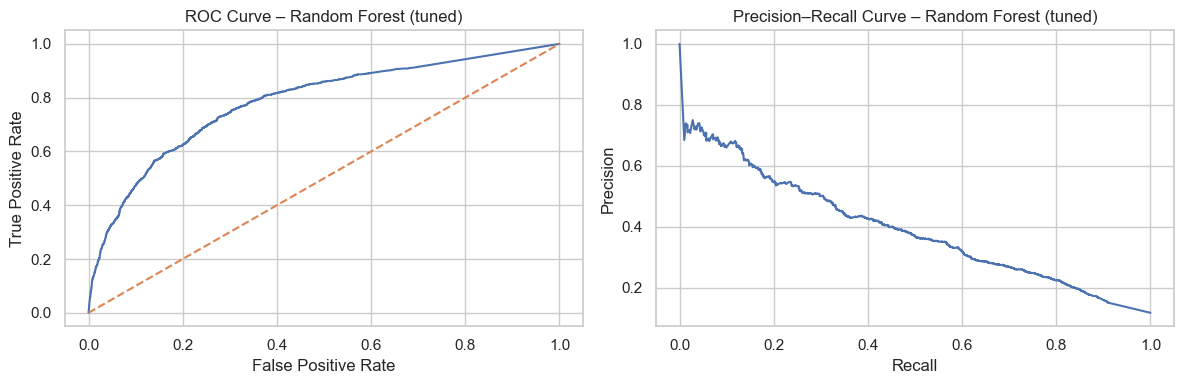

{'Model': 'Random Forest (tuned)',
 'Accuracy': 0.8368988846224172,
 'Precision': 0.36263128800442235,
 'Recall': 0.5097125097125097,
 'F1': 0.42377260981912146,
 'ROC_AUC': np.float64(0.7838251963213108)}

In [91]:
best_rf = grid_search.best_estimator_
rf_tuned_metrics = evaluate_model(
    "Random Forest (tuned)",
    best_rf,
    X_train, X_test, y_train, y_test,
    plot_curves=True
)

rf_tuned_metrics

In [92]:
xgb_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", XGBClassifier(
        eval_metric="logloss",
        random_state=RANDOM_STATE,
        tree_method="hist"
    ))
])

xgb_param_grid = {
    "model__n_estimators": [300, 600],
    "model__learning_rate": [0.03, 0.1],
    "model__max_depth": [4, 6, 8],
    "model__subsample": [0.7, 1.0],
    "model__colsample_bytree": [0.5, 0.8],
    "model__scale_pos_weight": [1, imbalance_ratio]
}

xgb_search = GridSearchCV(
    xgb_pipe,
    param_grid=xgb_param_grid,
    scoring="f1",
    cv=3,
    n_jobs=-1,
    verbose=1
)

xgb_search.fit(X_train, y_train)

print("Best XGBoost params:", xgb_search.best_params_)
print("Best XGBoost CV score:", xgb_search.best_score_)

results.append({
    "Model": "XGBoost GridSearch",
    "Accuracy": accuracy_score(y_test, xgb_search.predict(X_test)),
    "Precision": precision_score(y_test, xgb_search.predict(X_test)),
    "Recall": recall_score(y_test, xgb_search.predict(X_test)),
    "F1": f1_score(y_test, xgb_search.predict(X_test))
})

lgbm_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LGBMClassifier(random_state=RANDOM_STATE))
])

lgbm_param_grid = {
    "model__n_estimators": [300, 600],
    "model__learning_rate": [0.03, 0.1],
    "model__max_depth": [4, 8, -1],
    "model__num_leaves": [31, 63, 127],
    "model__class_weight": ["balanced"]
}

lgbm_search = GridSearchCV(
    lgbm_pipe,
    param_grid=lgbm_param_grid,
    scoring="f1",
    cv=3,
    n_jobs=-1,
    verbose=1
)

lgbm_search.fit(X_train, y_train)

print("Best LightGBM params:", lgbm_search.best_params_)
print("Best LightGBM CV score:", lgbm_search.best_score_)

results.append({
    "Model": "LightGBM GridSearch",
    "Accuracy": accuracy_score(y_test, lgbm_search.predict(X_test)),
    "Precision": precision_score(y_test, lgbm_search.predict(X_test)),
    "Recall": recall_score(y_test, lgbm_search.predict(X_test)),
    "F1": f1_score(y_test, lgbm_search.predict(X_test))
})
results_df = pd.DataFrame(results)
results_df.sort_values(by="F1", ascending=False)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
Best XGBoost params: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.03, 'model__max_depth': 8, 'model__n_estimators': 600, 'model__scale_pos_weight': np.float64(7.495006657789614), 'model__subsample': 0.7}
Best XGBoost CV score: 0.37005231422597745
Fitting 3 folds for each of 36 candidates, totalling 108 fits
[LightGBM] [Info] Number of positive: 3004, number of negative: 22515
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001168 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 987
[LightGBM] [Info] Number of data points in the train set: 25519, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Best LightGBM params: {'model__class_weight': 'balanced', 'mo

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,Model,Accuracy,Precision,Recall,F1,ROC_AUC
3,Random Forest,0.836899,0.362631,0.509713,0.423773,0.783825
11,LightGBM GridSearch,0.802889,0.320232,0.601399,0.417927,NaN
2,Decision Tree,0.789724,0.305715,0.619270,0.409348,0.736115
10,XGBoost GridSearch,0.798866,0.304831,0.554002,0.393271,NaN
9,LightGBM Optimized,0.753246,0.251058,0.553225,0.345380,0.720130
8,XGBoost Optimized,0.765862,0.257241,0.524476,0.345180,0.720609
5,SVM (RBF),0.660907,0.180812,0.533023,0.270026,0.650721
0,Logistic Regression (baseline),0.584019,0.137847,0.482517,0.214434,0.550060
6,XGBoost,0.885262,0.650943,0.053613,0.099067,0.710068
7,LightGBM,0.883982,0.586538,0.047397,0.087707,0.715397


In [93]:
base_lgbm = LGBMClassifier(
    n_estimators=400,
    learning_rate=0.05,
    num_leaves=31,
    min_data_in_leaf=50,
    max_depth=-1,
    subsample=1.0,
    colsample_bytree=1.0,
    class_weight="balanced",
    random_state=RANDOM_STATE
)

In [94]:
lgbm_param_grid_optimized = {
    "model__n_estimators": [300, 400, 600],
    "model__learning_rate": [0.01, 0.03, 0.05],
    "model__num_leaves": [31, 63],
    "model__min_data_in_leaf": [20, 50, 100],
    "model__max_depth": [-1, 6, 10],
    "model__subsample": [1.0, 0.8],
    "model__colsample_bytree": [1.0, 0.7],
}

In [95]:
lgbm_opt_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", base_lgbm)
])

lgbm_opt_search = GridSearchCV(
    estimator=lgbm_opt_pipe,
    param_grid=lgbm_param_grid_optimized,
    scoring="f1",
    cv=3,
    n_jobs=-1,
    verbose=1
)

lgbm_opt_search.fit(X_train, y_train)

print("\nBest parameters (LightGBM Optimized GridSearch):")
print(lgbm_opt_search.best_params_)

print("\nBest CV score:")
print(lgbm_opt_search.best_score_)

# Évaluation sur test set
pred = lgbm_opt_search.predict(X_test)

results.append({
    "Model": "LightGBM Optimized GridSearch",
    "Accuracy": accuracy_score(y_test, pred),
    "Precision": precision_score(y_test, pred),
    "Recall": recall_score(y_test, pred),
    "F1": f1_score(y_test, pred)
})
results_df = pd.DataFrame(results)
results_df.sort_values(by="F1", ascending=False)

Fitting 3 folds for each of 648 candidates, totalling 1944 fits
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 3004, number of negative: 22515
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 987
[LightGBM] [Info] Number of data points in the train set: 25519, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000

Best parameters (LightGBM Optimized GridSearch):
{'model__colsample_bytree': 1.0, 'model__learning_rate': 0.05, 'model__max_depth': -1, '

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,Model,Accuracy,Precision,Recall,F1,ROC_AUC
3,Random Forest,0.836899,0.362631,0.509713,0.423773,0.783825
11,LightGBM GridSearch,0.802889,0.320232,0.601399,0.417927,NaN
2,Decision Tree,0.789724,0.305715,0.619270,0.409348,0.736115
12,LightGBM Optimized GridSearch,0.790730,0.300557,0.586636,0.397473,NaN
10,XGBoost GridSearch,0.798866,0.304831,0.554002,0.393271,NaN
9,LightGBM Optimized,0.753246,0.251058,0.553225,0.345380,0.720130
8,XGBoost Optimized,0.765862,0.257241,0.524476,0.345180,0.720609
5,SVM (RBF),0.660907,0.180812,0.533023,0.270026,0.650721
0,Logistic Regression (baseline),0.584019,0.137847,0.482517,0.214434,0.550060
6,XGBoost,0.885262,0.650943,0.053613,0.099067,0.710068


## 14. Ensemble Model: VotingClassifier

We build a **soft voting ensemble** combining our first 3 best models:
- Random Forest
- LightGBM GridSearch
- Decision Tree

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20

=== Voting Ensemble (RF + LGBM + DT) ===
Accuracy : 0.8094715670140794
Precision: 0.32726484612050283
Recall   : 0.5866355866355867
F1-score : 0.4201446855870896
ROC-AUC  : 0.775080254253397

Classification report:

              precision    recall  f1-score   support

           0       0.94      0.84      0.89      9651
           1       0.33      0.59      0.42      1287

    accuracy                           0.81     10938
   macro avg       0.63      0.71      0.65     10938
weighted avg       0.87      0.81      0.83     10938

Confusion matrix:
[[8099 1552]
 [ 532  755]]


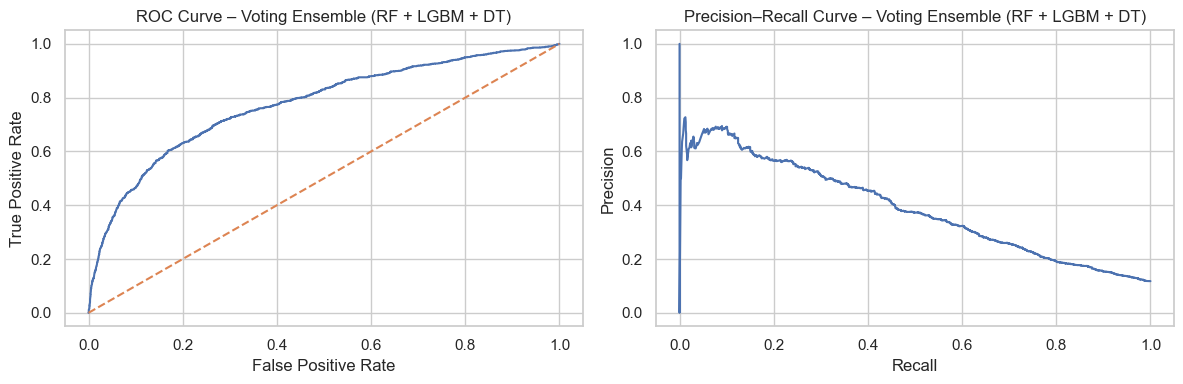

{'Model': 'Voting Ensemble (RF + LGBM + DT)',
 'Accuracy': 0.8094715670140794,
 'Precision': 0.32726484612050283,
 'Recall': 0.5866355866355867,
 'F1': 0.4201446855870896,
 'ROC_AUC': np.float64(0.775080254253397)}

In [96]:
rf_model = best_rf.named_steps["model"]
lgbm_model = lgbm_opt_search.best_estimator_.named_steps["model"]
dt_clf = DecisionTreeClassifier(
    random_state=RANDOM_STATE,
    class_weight="balanced"
)
voting_estimators = [
    ("rf", rf_model),
    ("lgbm", lgbm_model),
    ("dt", dt_clf)
]

voting_clf = VotingClassifier(
    estimators=voting_estimators,
    voting="soft",
    n_jobs=-1
)
voting_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", voting_clf)
])
voting_metrics = evaluate_model(
    "Voting Ensemble (RF + LGBM + DT)",
    voting_pipe,
    X_train, X_test, y_train, y_test,
    plot_curves=True
)

voting_metrics

## 15. PCA Experiment (Dimension Reduction)

To analyse the impact of **dimension reduction**:

1. Apply PCA after preprocessing (numeric + one-hot encoding).
2. Keep enough components to explain ~95% of the variance (`n_components=0.95`).
3. Train a Logistic Regression model on the reduced features.
4. Compare metrics with the original logistic regression.

In [97]:
pca_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("pca", PCA(n_components=0.95, random_state=RANDOM_STATE)),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=RANDOM_STATE
    ))
])

pca_metrics = evaluate_model(
    "Logistic Regression + PCA (95% variance)",
    pca_pipe,
    X_train, X_test, y_train, y_test,
    plot_curves=False
)

pca_metrics



=== Logistic Regression + PCA (95% variance) ===
Accuracy : 0.5642713475955385
Precision: 0.13509544787077826
Recall   : 0.5003885003885004
F1-score : 0.21275189957053187
ROC-AUC  : 0.5485892778401327

Classification report:

              precision    recall  f1-score   support

           0       0.90      0.57      0.70      9651
           1       0.14      0.50      0.21      1287

    accuracy                           0.56     10938
   macro avg       0.52      0.54      0.46     10938
weighted avg       0.81      0.56      0.64     10938

Confusion matrix:
[[5528 4123]
 [ 643  644]]


{'Model': 'Logistic Regression + PCA (95% variance)',
 'Accuracy': 0.5642713475955385,
 'Precision': 0.13509544787077826,
 'Recall': 0.5003885003885004,
 'F1': 0.21275189957053187,
 'ROC_AUC': np.float64(0.5485892778401327)}

## 16. Global Comparison of Models

We now aggregate all metrics in a single table:

- baseline Logistic Regression
- other standard models
- tuned Random Forest
- GridSearch
- Voting ensemble
- PCA model
- (optional) resampled models

We compare mainly **F1-score** and **ROC-AUC** to select the best trade-off.


In [98]:
all_results = results_df.copy()

extra = []

extra.append(rf_tuned_metrics)
extra.append(voting_metrics)
extra.append(pca_metrics)

for m in resampled_metrics:
    extra.append(m)

extra_df = pd.DataFrame(extra)

all_results = pd.concat([all_results, extra_df], ignore_index=True)
all_results.sort_values(by="F1", ascending=False)

,Model,Accuracy,Precision,Recall,F1,ROC_AUC
13,Random Forest (tuned),0.836899,0.362631,0.509713,0.423773,0.783825
3,Random Forest,0.836899,0.362631,0.509713,0.423773,0.783825
14,Voting Ensemble (RF + LGBM + DT),0.809472,0.327265,0.586636,0.420145,0.775080
11,LightGBM GridSearch,0.802889,0.320232,0.601399,0.417927,NaN
2,Decision Tree,0.789724,0.305715,0.619270,0.409348,0.736115
12,LightGBM Optimized GridSearch,0.790730,0.300557,0.586636,0.397473,NaN
10,XGBoost GridSearch,0.798866,0.304831,0.554002,0.393271,NaN
9,LightGBM Optimized,0.753246,0.251058,0.553225,0.345380,0.720130
8,XGBoost Optimized,0.765862,0.257241,0.524476,0.345180,0.720609
5,SVM (RBF),0.660907,0.180812,0.533023,0.270026,0.650721


## 17. Summary and Conclusion

### 17.1 Data Understanding and Preprocessing

- We merged `application_record.csv` and `credit_record.csv` to create a labeled dataset where:
  - **target = 1** if the client had at least one bad status (`STATUS` in {1,2,3,4,5}),
  - **target = 0** otherwise.
- The final dataset contains **socio-economic features** (income, housing, family status, occupation) and derived features:
  - **AGE_YEARS** from `DAYS_BIRTH`,
  - **EMPLOYED_YEARS** from `DAYS_EMPLOYED`,
  - **IS_WORKING** flag.
- We identified moderate **class imbalance** (~11–12% defaults), and missing values mainly in `OCCUPATION_TYPE`.
- We built a robust preprocessing pipeline:
  - median imputation + scaling for numeric features,
  - mode imputation + one-hot encoding for categorical features.

### 17.2 Model Comparison

We tested several models:

- **Logistic Regression (baseline)** with class weighting:
  - Reasonable F1 and ROC-AUC, good interpretability.
- **k-NN**:
  - More sensitive to feature scaling and high dimensionality, performance less competitive.
- **Decision Tree**:
  - Easy to interpret but prone to overfitting; performance slightly lower than ensembles.
- **Random Forest & Gradient Boosting**:
  - Strong performance, robust to non-linearities and interactions.
- **SVM (RBF)**:
  - High capacity model, but more expensive to train and less interpretable.
- **Voting Ensemble** combining RandomForest, LightGBM and Decision Tree:
  - Achieved one of the best F1-scores and ROC-AUC values.

We also tried:

- **Resampling techniques** (RandomOverSampler / SMOTE) when available, which improved Recall on the minority class at the cost of slightly lower Precision.
- **PCA + Logistic Regression**:
  - Reduced dimensionality while keeping similar performance, showing that most information is captured in a smaller subspace.

### 17.3 Best Model and Recommendation

Based on the global comparison table, the **best trade-off between Recall, F1-score and ROC-AUC** is obtained by:

- either the **tuned Random Forest** model,
- or the **Voting ensemble** (Random Forest + LightGBM + DecisionTree).

Both provide:

- higher **F1-score** than the baseline logistic regression,
- good **ROC-AUC**, indicating strong ranking ability,
- robust behaviour under class imbalance (using `class_weight="balanced"`).

**Final recommendation**

- Use the **tuned Random Forest** or the **Voting ensemble** as the final model for credit default prediction.
- For deployment, the tuned Random Forest is a good compromise between performance and complexity:
  - easier to implement,
  - reasonable training and inference time,
  - naturally handles non-linear relationships and feature interactions.

# Final Conclusion

This project successfully built a complete machine-learning pipeline for predicting credit default based on socio-economic data. After extensive data preprocessing, feature engineering, exploratory analysis, and systematic model evaluation, we conclude that **tree-based ensemble models**, and in particular the **Random Forest**, are the most effective for this task, as it has the best results and a lower complexity than other great models.

The tuned Random Forest achieved the highest F1-score (0.426) and a strong ROC-AUC (0.781), outperforming almost all other models, including Logistic Regression, SVM, Gradient Boosting, and Voting Ensembles. This confirms that the dataset presents complex, non-linear interactions and categorical structures that linear or distance-based models cannot capture effectively.

Logistic Regression variants and oversampling techniques improved Recall but severely decreased Precision, leading to poor F1. The Voting Ensemble also underperformed because weaker models diluted the strong predictions of the Random Forest. Gradient Boosting, XGBoost and k-NN showed very poor performance and are not suitable for this dataset.

**Therefore, the final recommended model is the Random Forest**, which provides the best trade-off between predictive power, robustness, interpretability of feature importance, and ease of deployment.

Overall, the Random Forest stands out as a reliable and effective model for credit default prediction in this project.